In [162]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)


In [163]:
df = pd.read_csv('suicide_ds_2016.csv')

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [165]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [166]:
df.tail()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.675,"63,067,077,179",2309,Boomers


In [167]:
df.nunique()

country                 101
year                     32
sex                       2
age                       6
suicides_no            2084
population            25564
suicides/100k pop      5298
country-year           2321
HDI for year            305
 gdp_for_year ($)      2321
gdp_per_capita ($)     2233
generation                6
dtype: int64

In [168]:
df.isna().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

# Tidy data
- Drop columns:
    - remove HDI for year
    - remove country-year
- Rename columns:
    - 'suicides/100k pop'  => suicides_per_100k_pop
    - ' gdp_for_year ($) ' => gdp_for_year
    - 'gdp_per_capita ($)' => gdp_per_capita
- Remove data points:
    - remove data from 2016 due to incompleteness

In [169]:
# HDI has a lot of missing data -> drop the column
# country-year is not needed -> drop
# generation also controversial according to kaggle examples
tidy_df = df.drop(['HDI for year', 'country-year'], axis='columns')

# rename collumns to be snake case confirm and remove currency
tidy_df = tidy_df.rename(columns=
    {
        'suicides/100k pop': 'suicides_per_100k_pop',
        # the extra spaces in the name below are intended!
        ' gdp_for_year ($) ': 'gdp_for_year',
        'gdp_per_capita ($)':'gdp_per_capita'
    })
tidy_df.columns


Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_per_100k_pop', 'gdp_for_year', 'gdp_per_capita',
       'generation'],
      dtype='object')

In [170]:
# find missing rows
counts = tidy_df.groupby(['country', 'year']).count()
counts.where(counts < 12).dropna()
# for 16 countries there is data missing in 2016 
# => remove that year to prevent misinterpretation
tidy_df = tidy_df[tidy_df['year'] != 2016]

Text(0, 0.5, 'frequency')

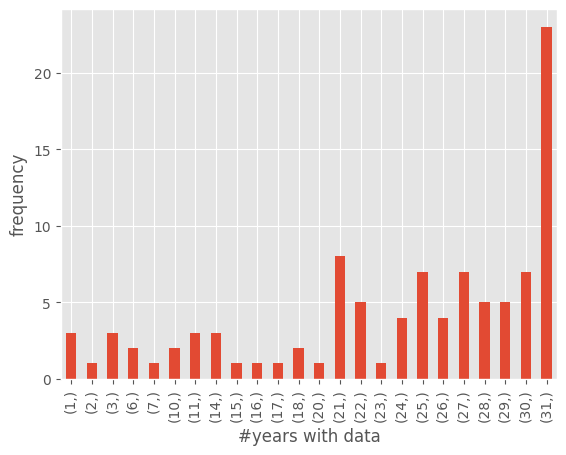

In [171]:
temp = tidy_df.groupby(['country', 'year']).count().reset_index()
temp = temp[['country','year']]
country_years = temp.groupby('country').count()
ax = country_years.value_counts(sort=False).plot.bar()
ax.set_xlabel('#years with data')
ax.set_ylabel('frequency')

plot above shows available data.  
31 is max (1985 to 2015)  
Whats a reasonable cutoff?  
10 years?

In [172]:
# get country names with less than k years of data available
temp = country_years.reset_index()
names = temp[temp.year < 10].country.values
names

array(['Bosnia and Herzegovina', 'Cabo Verde', 'Dominica', 'Macau',
       'Nicaragua', 'Oman', 'Saint Kitts and Nevis', 'San Marino',
       'Turkey', 'United Arab Emirates'], dtype=object)

In [173]:
# remove countries determined above by using .isin with the prepended negation (~))
tidy_df = tidy_df[~tidy_df['country'].isin(names)]

# Get total suicides per country and year
confused about per 100k colum: how to aggregate them to get per year value? mean? does not seem to fit visualizations on kaggle 
=> not possible. simply recalcualte by summing population and suicides_no in all categories and them take the mean over the years

In [174]:
# by_country = df.groupby('country')['suicides/100k pop']
# by_country.mean().mean()

In [175]:
# country_year_gby = df.groupby(['country','year'])['suicides/100k pop']
# country_year_gby.describe()

In [176]:
# country_year_gby.mean()

In [180]:
# france[['year','suicides/100k pop']]
# france = df[df.country == 'France']
# france = france[france.year.between(1985,2015)]
# ger = df[df.country == 'Germany']
# # not really needed, only data from 1990 to 2015 available
# ger = ger[ger.year.between(1985,2015)]
# ger_year = ger.groupby('year')
# ger_year.sum(numeric_only=True)

country
Germany    14.405722
Name: per100k, dtype: float64


<AxesSubplot: ylabel='country'>

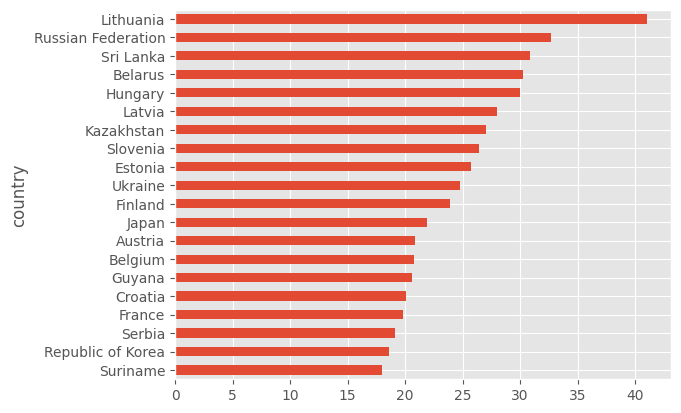

In [184]:
by_country_and_year = tidy_df.groupby(['country', 'year'])[
    ['population', 'suicides_no']].sum(numeric_only=True)
by_country_and_year['per100k'] = (
    by_country_and_year['suicides_no'] / by_country_and_year['population']) * 100_000
# by_country_and_year[['country','per100k']].mean('per100k')
country_alltime_avg = by_country_and_year.groupby('country').mean('per100k')
country_alltime_avg = country_alltime_avg.per100k
print(country_alltime_avg.filter(items=['Germany']))
country_alltime_avg = country_alltime_avg.sort_values()
country_alltime_avg[-20:].plot.barh()
# country_alltime_avg.plot.barh(x='per100k', y='country')
# country_alltime_avg.per100k.plot.barh()


/var/folders/v4/5kdk6t_57x3gwhsz8x8jl_900000gn/T/ipykernel_47588/3870688284.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

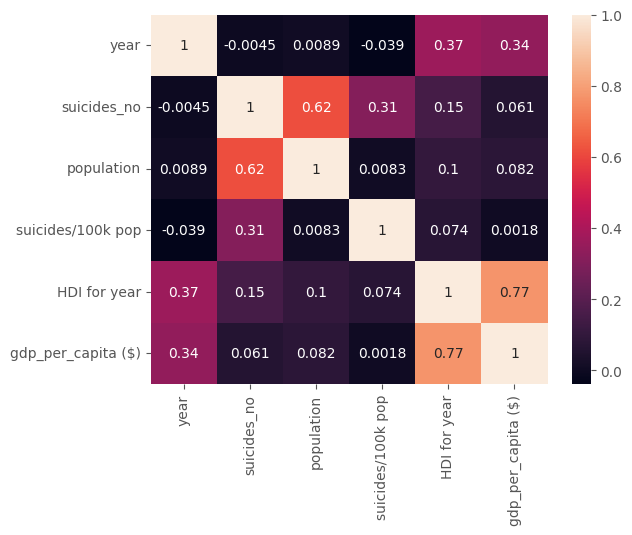

In [179]:
corr = df.corr()
sns.heatmap(corr, annot=True)